# Modeling Housing Prices on Ames IA Dataset

### Import Libraries and set Tensorflows environment

In [1]:


import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import itertools
from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
# Import Data
x = pd.read_csv("data/features.csv", index_col = 0)
y = pd.read_csv("data/target.csv", index_col = 0)

### Train-Test-Split the data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [4]:
X_train.shape

(970, 17)

### Instantiate and fit Linear Model

In [5]:
# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
y_pred = lr.predict(X_test)

In [7]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [8]:
error(y_test, np.exp(y_pred))

SalePrice    0.148273
dtype: float64

### Visualize Model Performance

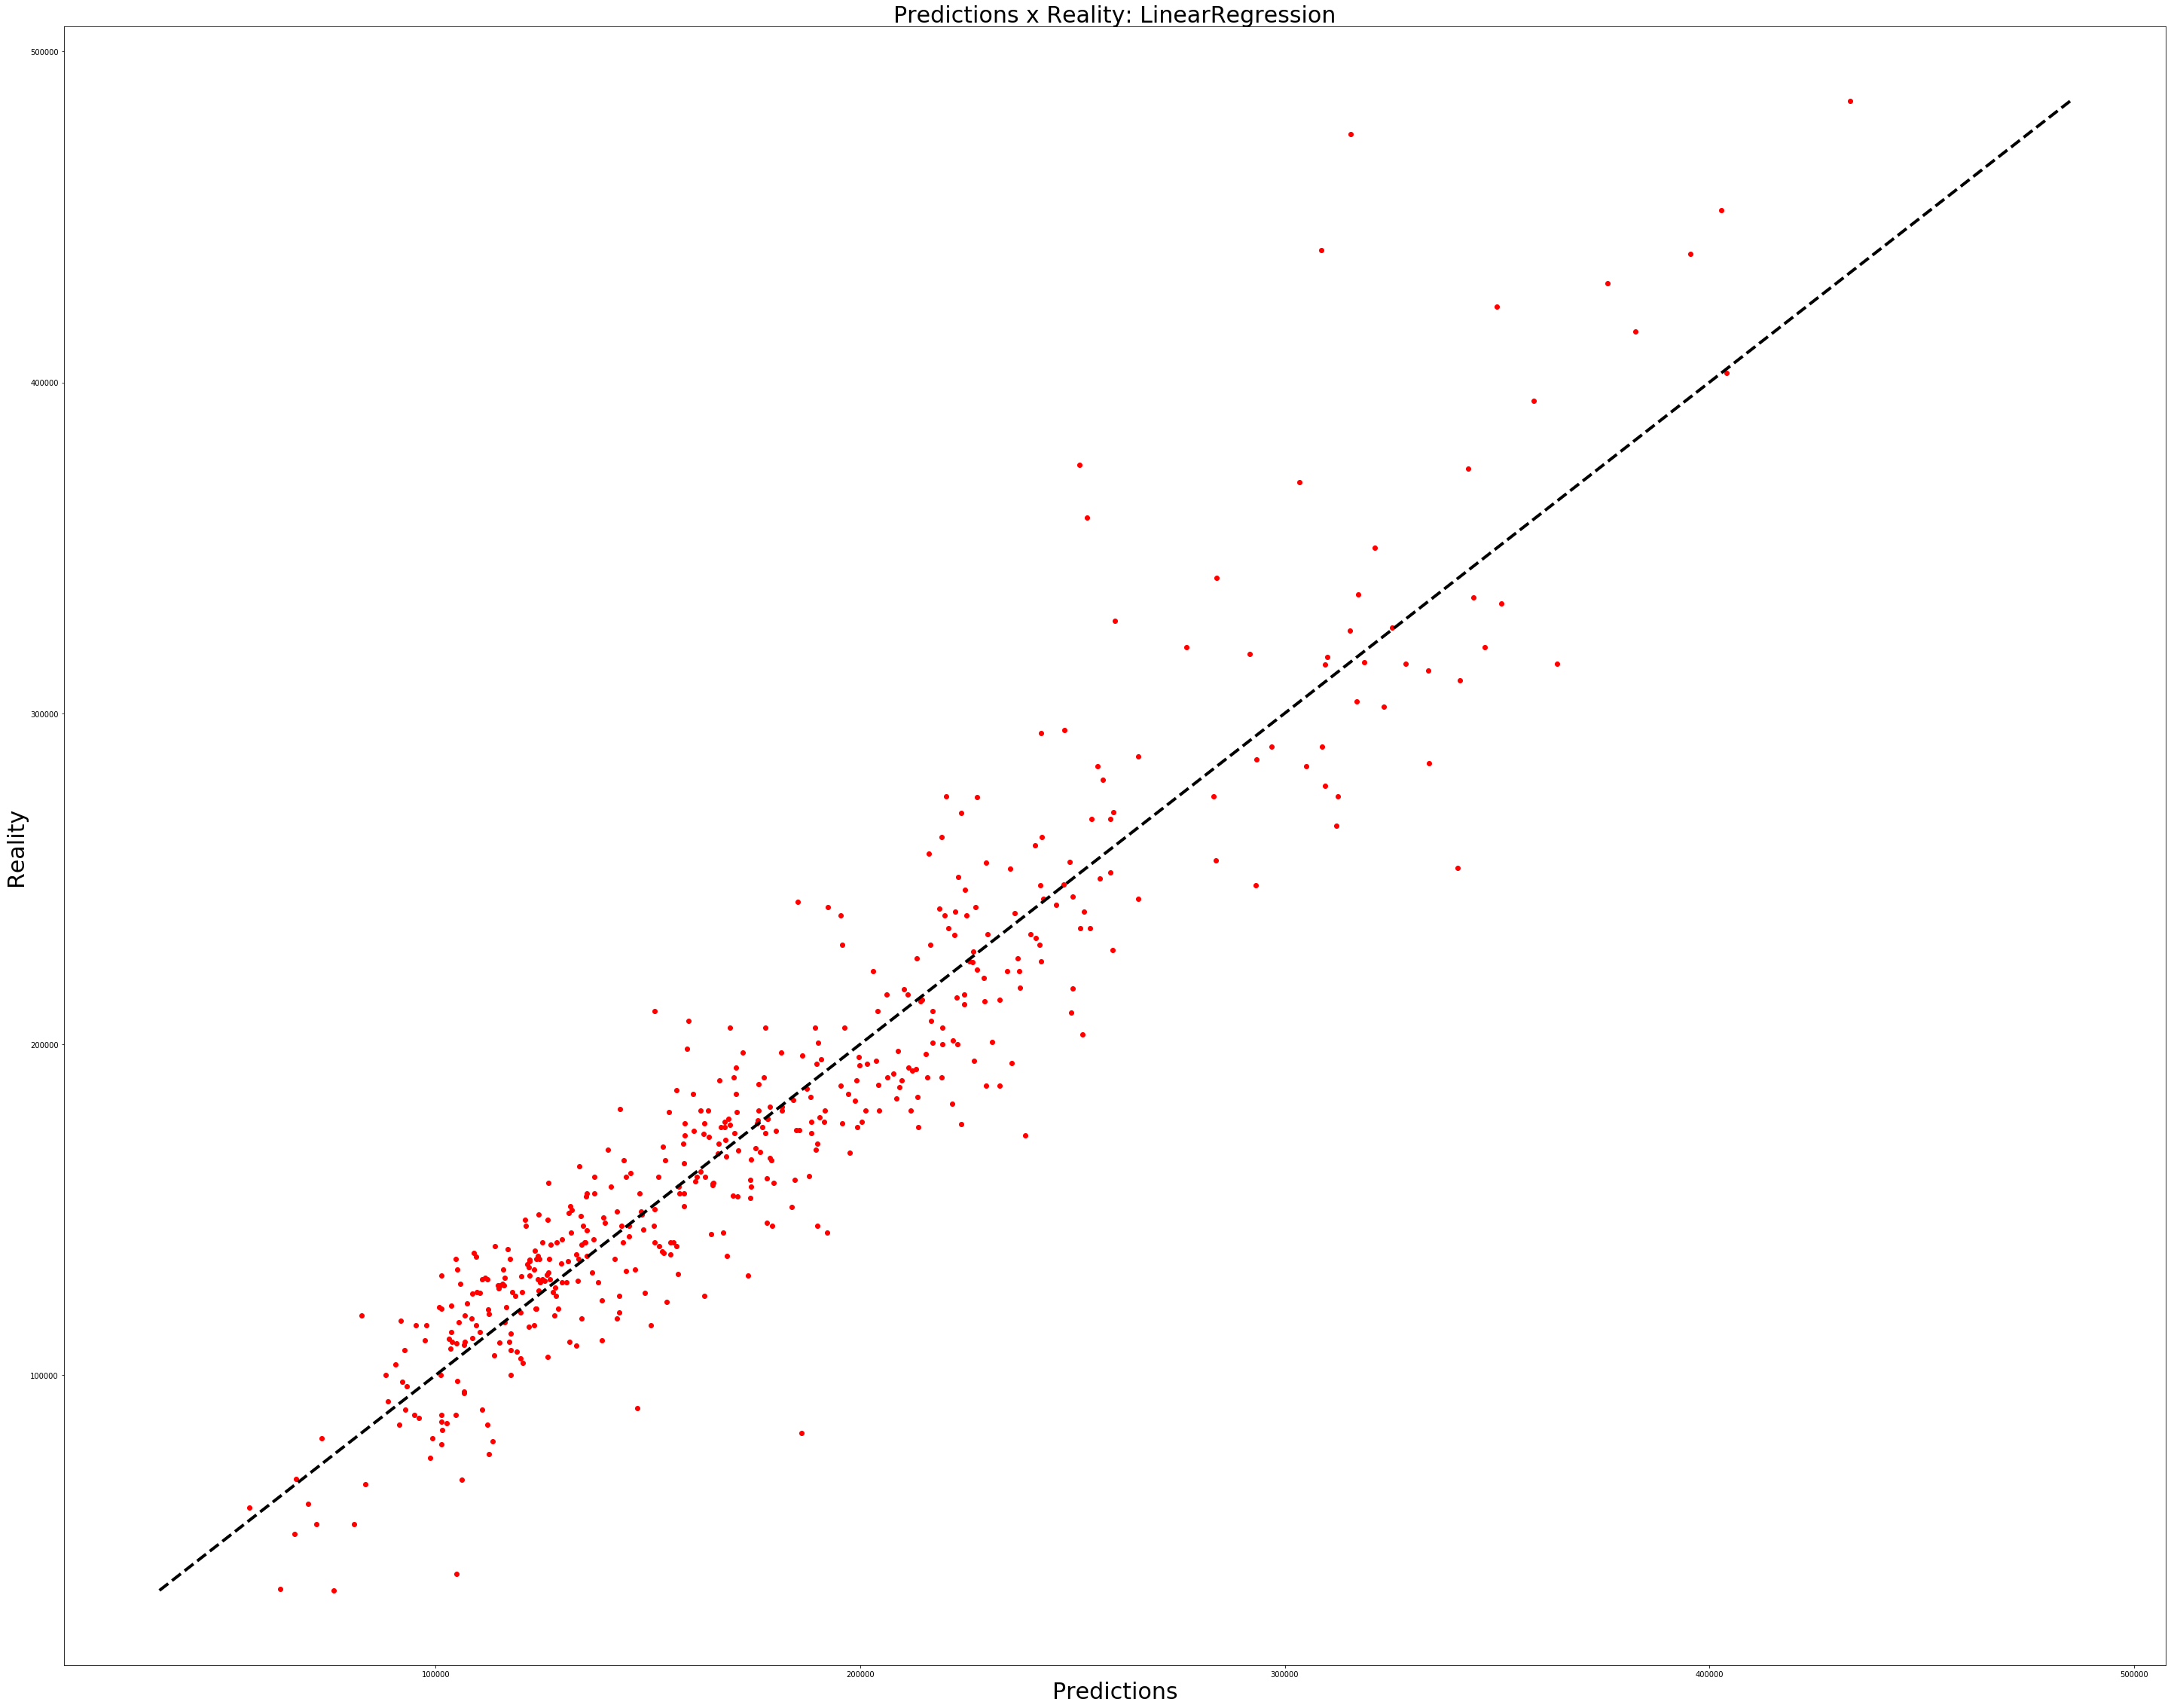

In [9]:

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(np.exp(y_pred), y_test, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality: LinearRegression', fontsize = 30)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

In [10]:
# Interpretation of Features
features_df = pd.DataFrame(lr.coef_.T, X_train.columns, columns=['Importance'])



features_df['abs'] = np.abs(features_df['Importance'])
features_df.sort_values('abs', ascending = False)

,Importance,abs
GrLivArea,0.402479,0.402479
TotalBsmtSF,-0.127412,0.127412
KitchenQual_E,0.071156,0.071156
GarageCars,0.040808,0.040808
OverallQual,0.033867,0.033867
BsmtQual_E,0.029727,0.029727
FullBath,-0.029067,0.029067
GarageFinish_E,0.026181,0.026181
TotalBsmtSF2,0.020928,0.020928
Neighborhood_E,0.013468,0.013468


### Use Tensoflows API to run DNNRegressor

In [11]:
# Import Data
x = pd.read_csv("data/features.csv", index_col = 0)
y = pd.read_csv("data/target.csv", index_col = 0)

In [12]:
# Scale our data for Tensoflows
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x),
                  columns = x.columns, index = x.index)
scaler_y = MinMaxScaler()
y = pd.DataFrame(scaler_y.fit_transform(y),
                 columns= y.columns, index = y.index)


In [13]:
x.head()

,OverallQual,GrLivArea,GarageCars,YearBuilt,GarageArea,FullBath,TotalBsmtSF,ExterQual_E,BsmtQual_E,KitchenQual_E,Neighborhood_E,GarageFinish_E,GarageType_E,Foundation_E,OverallQual2,TotalBsmtSF2,Neighborhood_E2
0,0.666667,0.686018,0.50,0.949275,0.871552,0.666667,0.836537,0.666667,0.75,0.666667,0.666667,0.666667,0.833333,1.0,0.484848,0.699794,0.461538
1,0.555556,0.558302,0.50,0.753623,0.847414,0.666667,0.884574,0.333333,0.75,0.333333,0.833333,0.666667,0.833333,0.4,0.353535,0.782471,0.705128
2,0.666667,0.704301,0.50,0.934783,0.885882,0.666667,0.845458,0.666667,0.75,0.666667,0.666667,0.666667,0.833333,1.0,0.484848,0.714799,0.461538
3,0.666667,0.687736,0.75,0.311594,0.893388,0.333333,0.821168,0.333333,0.50,0.666667,0.708333,0.333333,0.333333,0.2,0.484848,0.674317,0.517628
4,0.777778,0.791579,0.75,0.927536,0.929819,0.666667,0.872532,0.666667,0.75,0.666667,1.000000,0.666667,0.833333,1.0,0.636364,0.761313,1.000000


In [14]:
feature_names = x.columns

In [15]:
# List of features
engineered_features = []

for continuous_feature in feature_names:
    engineered_features.append(
        tf.feature_column.numeric_column(continuous_feature))

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(x ,
                                                    y, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = ['SalePrice'])
y_test  = pd.DataFrame(y_test, columns = ['SalePrice'])

training_set = pd.DataFrame(x_train, columns = feature_names).merge(y_train, left_index = True, right_index = True)
testing_set  = pd.DataFrame(x_test, columns = feature_names).merge(y_test, left_index = True, right_index = True)




### Define our input functions and model

In [16]:
def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in feature_names}
    
    
    feature_cols = dict(list(continuous_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set['SalePrice'].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.estimator.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\zgebl\\AppData\\Local\\Temp\\tmpas9m09_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:

# Deep Neural Network Regressor on our training data

regressor.train(input_fn = lambda: input_fn_new(training_set) , steps=5000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSa

In [18]:
# Evaluate our model on the testing data
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-06T17:28:57Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\zgebl\AppData\Local\Temp\tmpas9m09_2\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Inference Time : 0.26577s
INFO:tensorflow:Finished evaluation at 2020-04-06-17:28:58
INFO:tensorflow:S

In [19]:
# Model performance on testing data
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))


Final Loss on the testing set: 0.004954


### Visualize Model performance

In [20]:

y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

pred_values = [d['predictions'] for d in predictions]
pred_list = [d[0] for d in pred_values]
pred_df = pd.DataFrame(pred_list)



INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\zgebl\AppData\Local\Temp\tmpas9m09_2\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
predictions = pd.DataFrame(scaler_y.inverse_transform(pred_df), columns=['Predictions'])
reality = pd.DataFrame(scaler_y.inverse_transform(np.array(testing_set.SalePrice).reshape(-1,1)), columns=['Reality'])

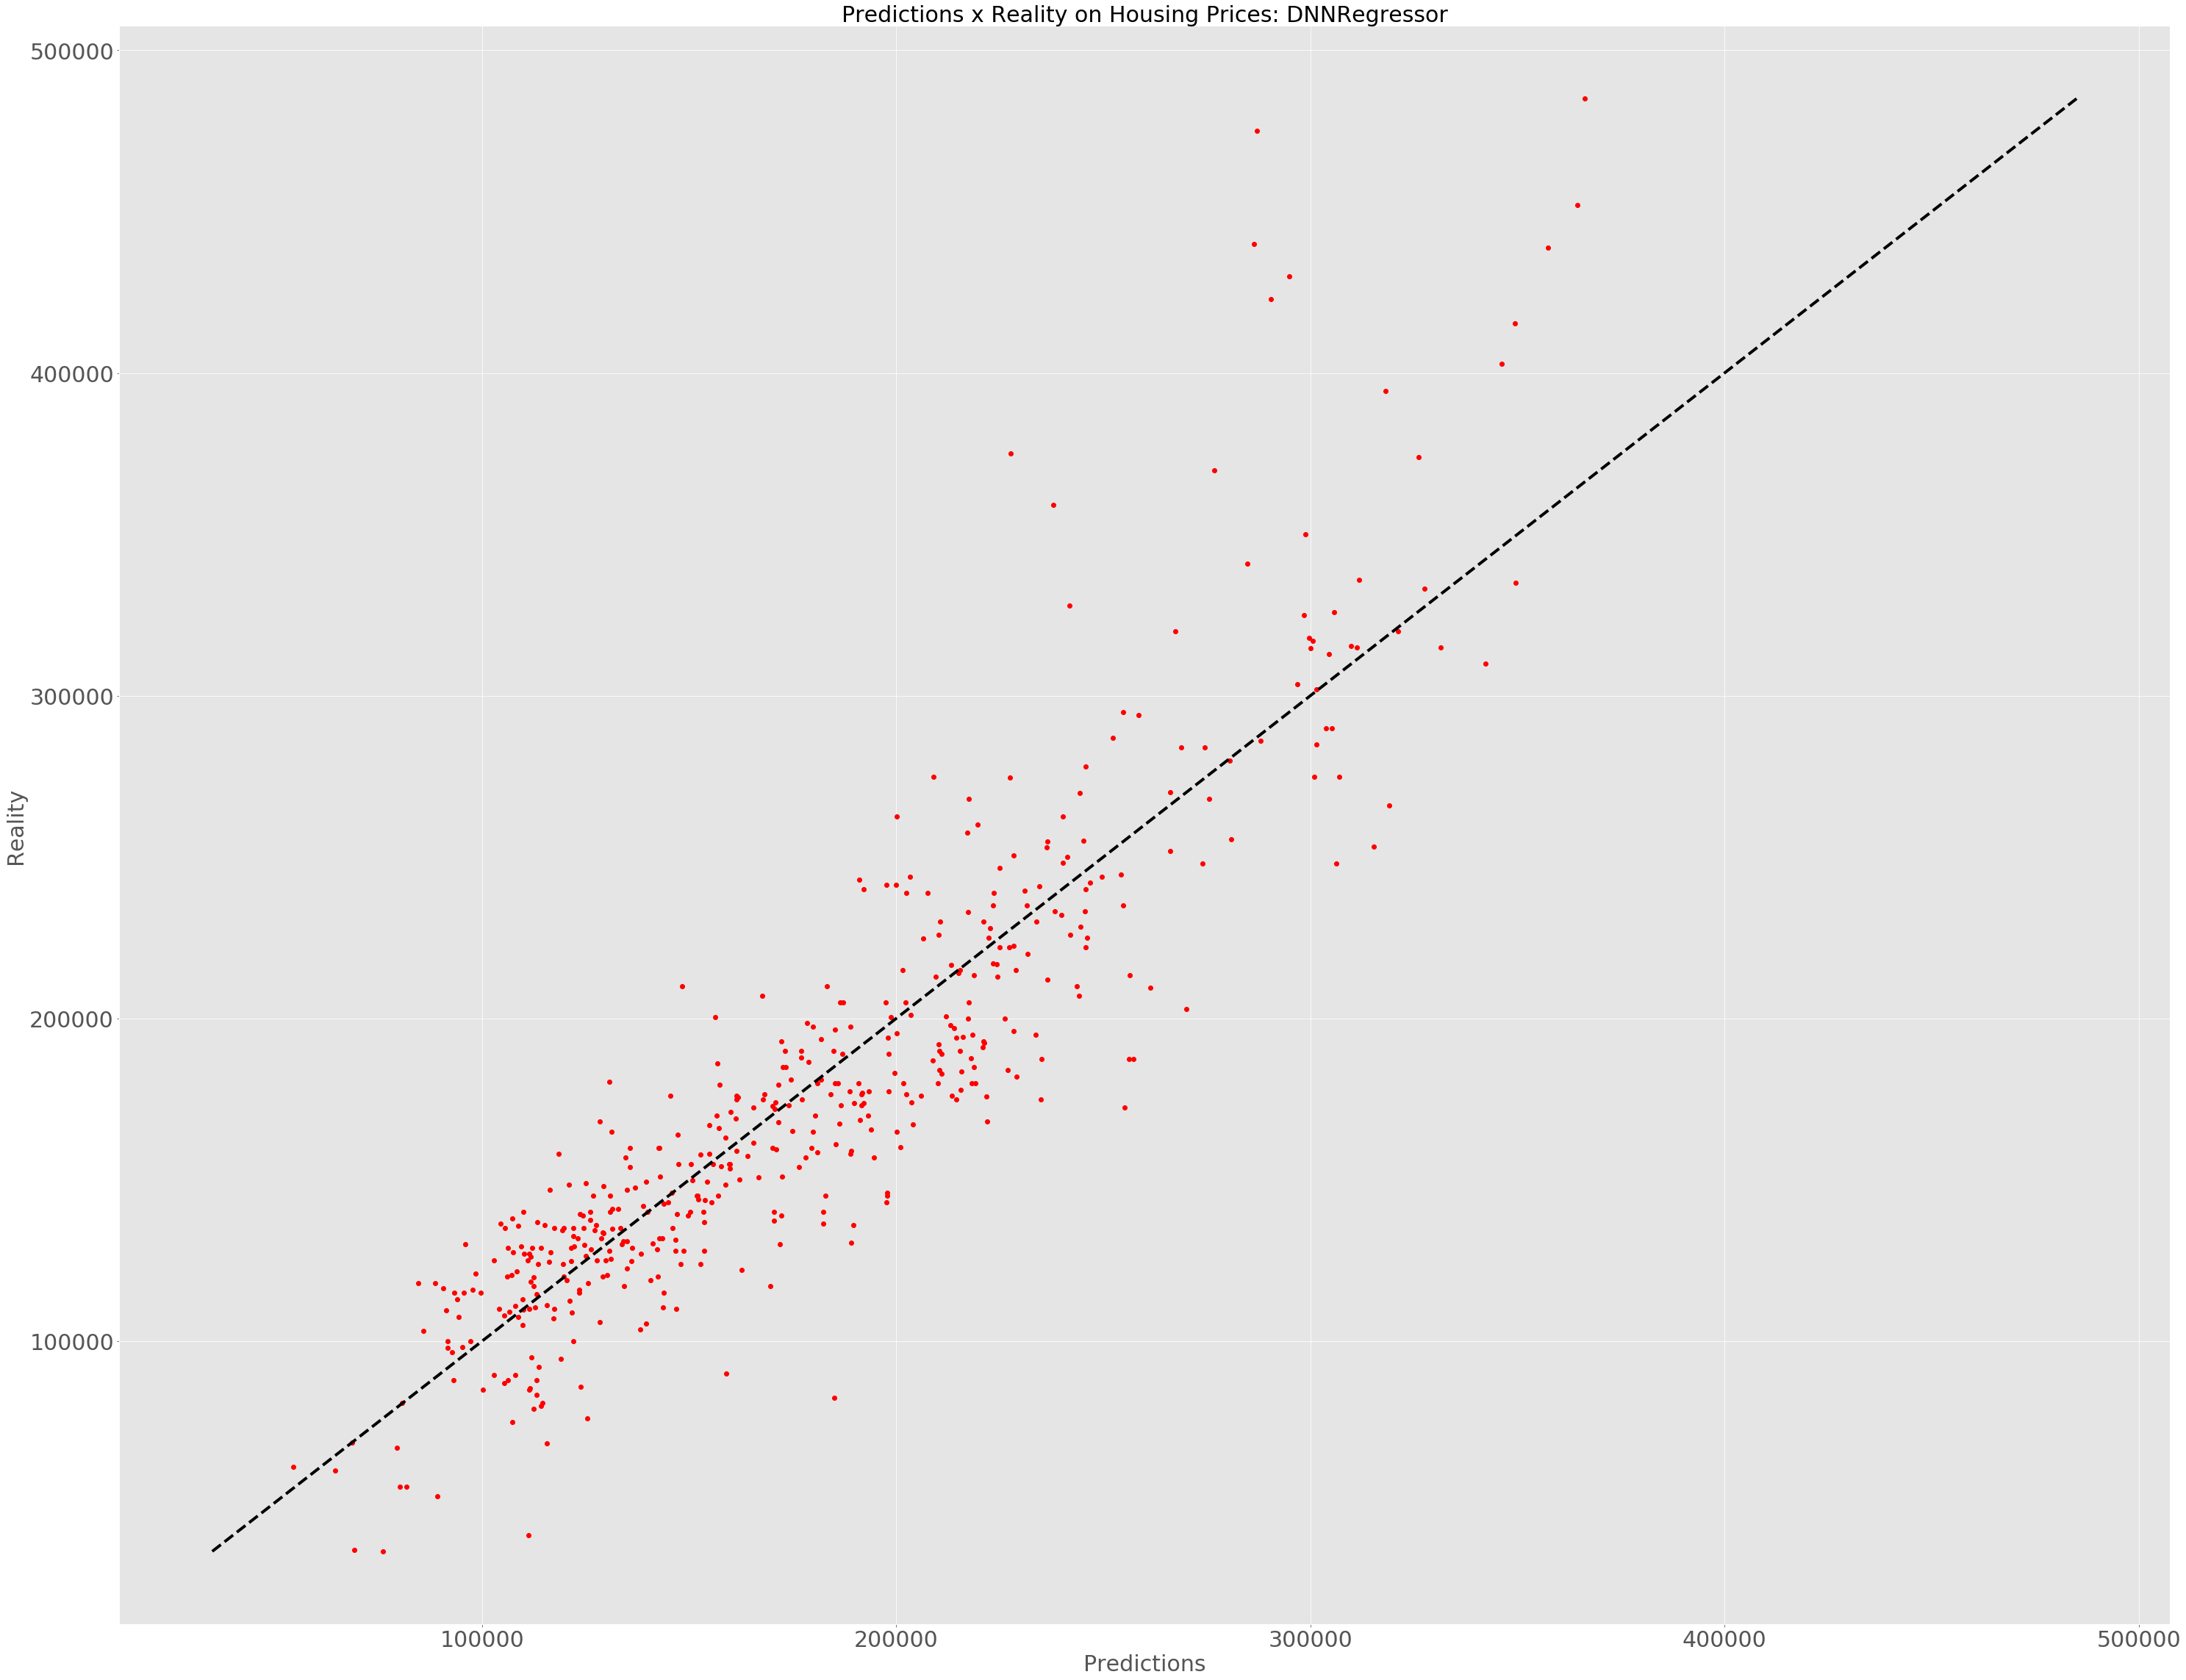

In [23]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on Housing Prices: DNNRegressor', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()